## Feature Engineering
1. Exploratory plots
2. PCA and scaler plots
3. Forward backward selection

In [23]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math
import numpy as np

# Read cleaned training dataset
train_df = pd.read_csv("data/final_data_train.csv", parse_dates=["ts"])

# Quick check
print(train_df.shape)
print(train_df.head())

# Ensure timestamp is sorted
train_df = train_df.sort_values("ts").reset_index(drop=True)

# Add time-based features for later analysis
train_df["hour"] = train_df["ts"].dt.hour
train_df["day"] = train_df["ts"].dt.day
train_df["month"] = train_df["ts"].dt.month
train_df["weekday"] = train_df["ts"].dt.weekday

(22422, 33)
                   ts     power  mean_IGR_Nex  mean_IGR_Hammer_Odde_Fyr  \
0 2021-01-01 00:00:00  0.133746           0.0                       0.0   
1 2021-01-01 01:00:00  0.221838           0.0                       0.0   
2 2021-01-01 02:00:00  0.154125           0.0                       0.0   
3 2021-01-01 03:00:00  0.127054           0.0                       0.0   
4 2021-01-01 04:00:00  0.099059           0.0                       0.0   

   max_temp_Nex  max_temp_Hammer_Odde_Fyr  mean_temp_Nex  \
0           3.8                       3.2            3.6   
1           3.7                       3.1            3.5   
2           3.8                       2.8            3.3   
3           2.9                       2.6            2.5   
4           2.4                       2.4            2.2   

   mean_temp_Hammer_Odde_Fyr  min_temp_Nex  min_temp_Hammer_Odde_Fyr  ...  \
0                        2.9           3.4                       2.7  ...   
1                     

In [24]:
# Select features (skip ImbalanceMWh, keep everything else)
features = [
    "power", "mean_IGR_Nex", "max_temp_Nex", "mean_temp_Nex", "min_temp_Nex",
    "mean_hum_Nex", "prec_Nex", "mean_wind_speed_Nex", "mean_wind_dir_Nex",
    "DK2_DKK", "SYSTEM_DKK", "ImbalancePriceDKK",
    "BalancingPowerPriceUpDKK", "BalancingPowerPriceDownDKK"
]

# Drop non-numeric columns like PriceArea
numeric_df = train_df[features]

## 1. Exploratory plots

### 📊 Insights from Boxplots & Histograms

- **Power distribution**
  - Highly skewed, with many hours of very low or zero generation.  
  - Reflects periods of calm winds where the turbines produce little to no power.  
  - Outliers correspond to occasional very high production values.

- **Weather features**
  - **Temperatures (min, mean, max)**: bell-shaped, seasonal, and strongly correlated with each other.  
  - **Humidity**: distribution skewed toward higher values (often 70–100%), consistent with Danish climate.  
  - **Precipitation**: mostly zero, with occasional peaks — confirming that precipitation is sparse but intense when it occurs.  
  - **Wind speed**: approximately Weibull-like distribution, peaking around moderate values, as expected for wind resources.  
  - **Wind direction**: nearly uniform with some dominant peaks (to be further analyzed with wind rose plots).  
  - **Irradiance (IGR)**: long right-skewed distribution, with many near-zero values (nighttime) and fewer high daytime peaks.

- **Market prices**
  - All price variables (DK2, System, Balancing Up/Down, Imbalance) show a **heavy right skew**.  
  - Long tails with extreme outliers reflect episodes of very high spot or balancing prices.  
  - Central tendency lies at a few hundred DKK, but spikes can reach above 5000–8000 DKK.

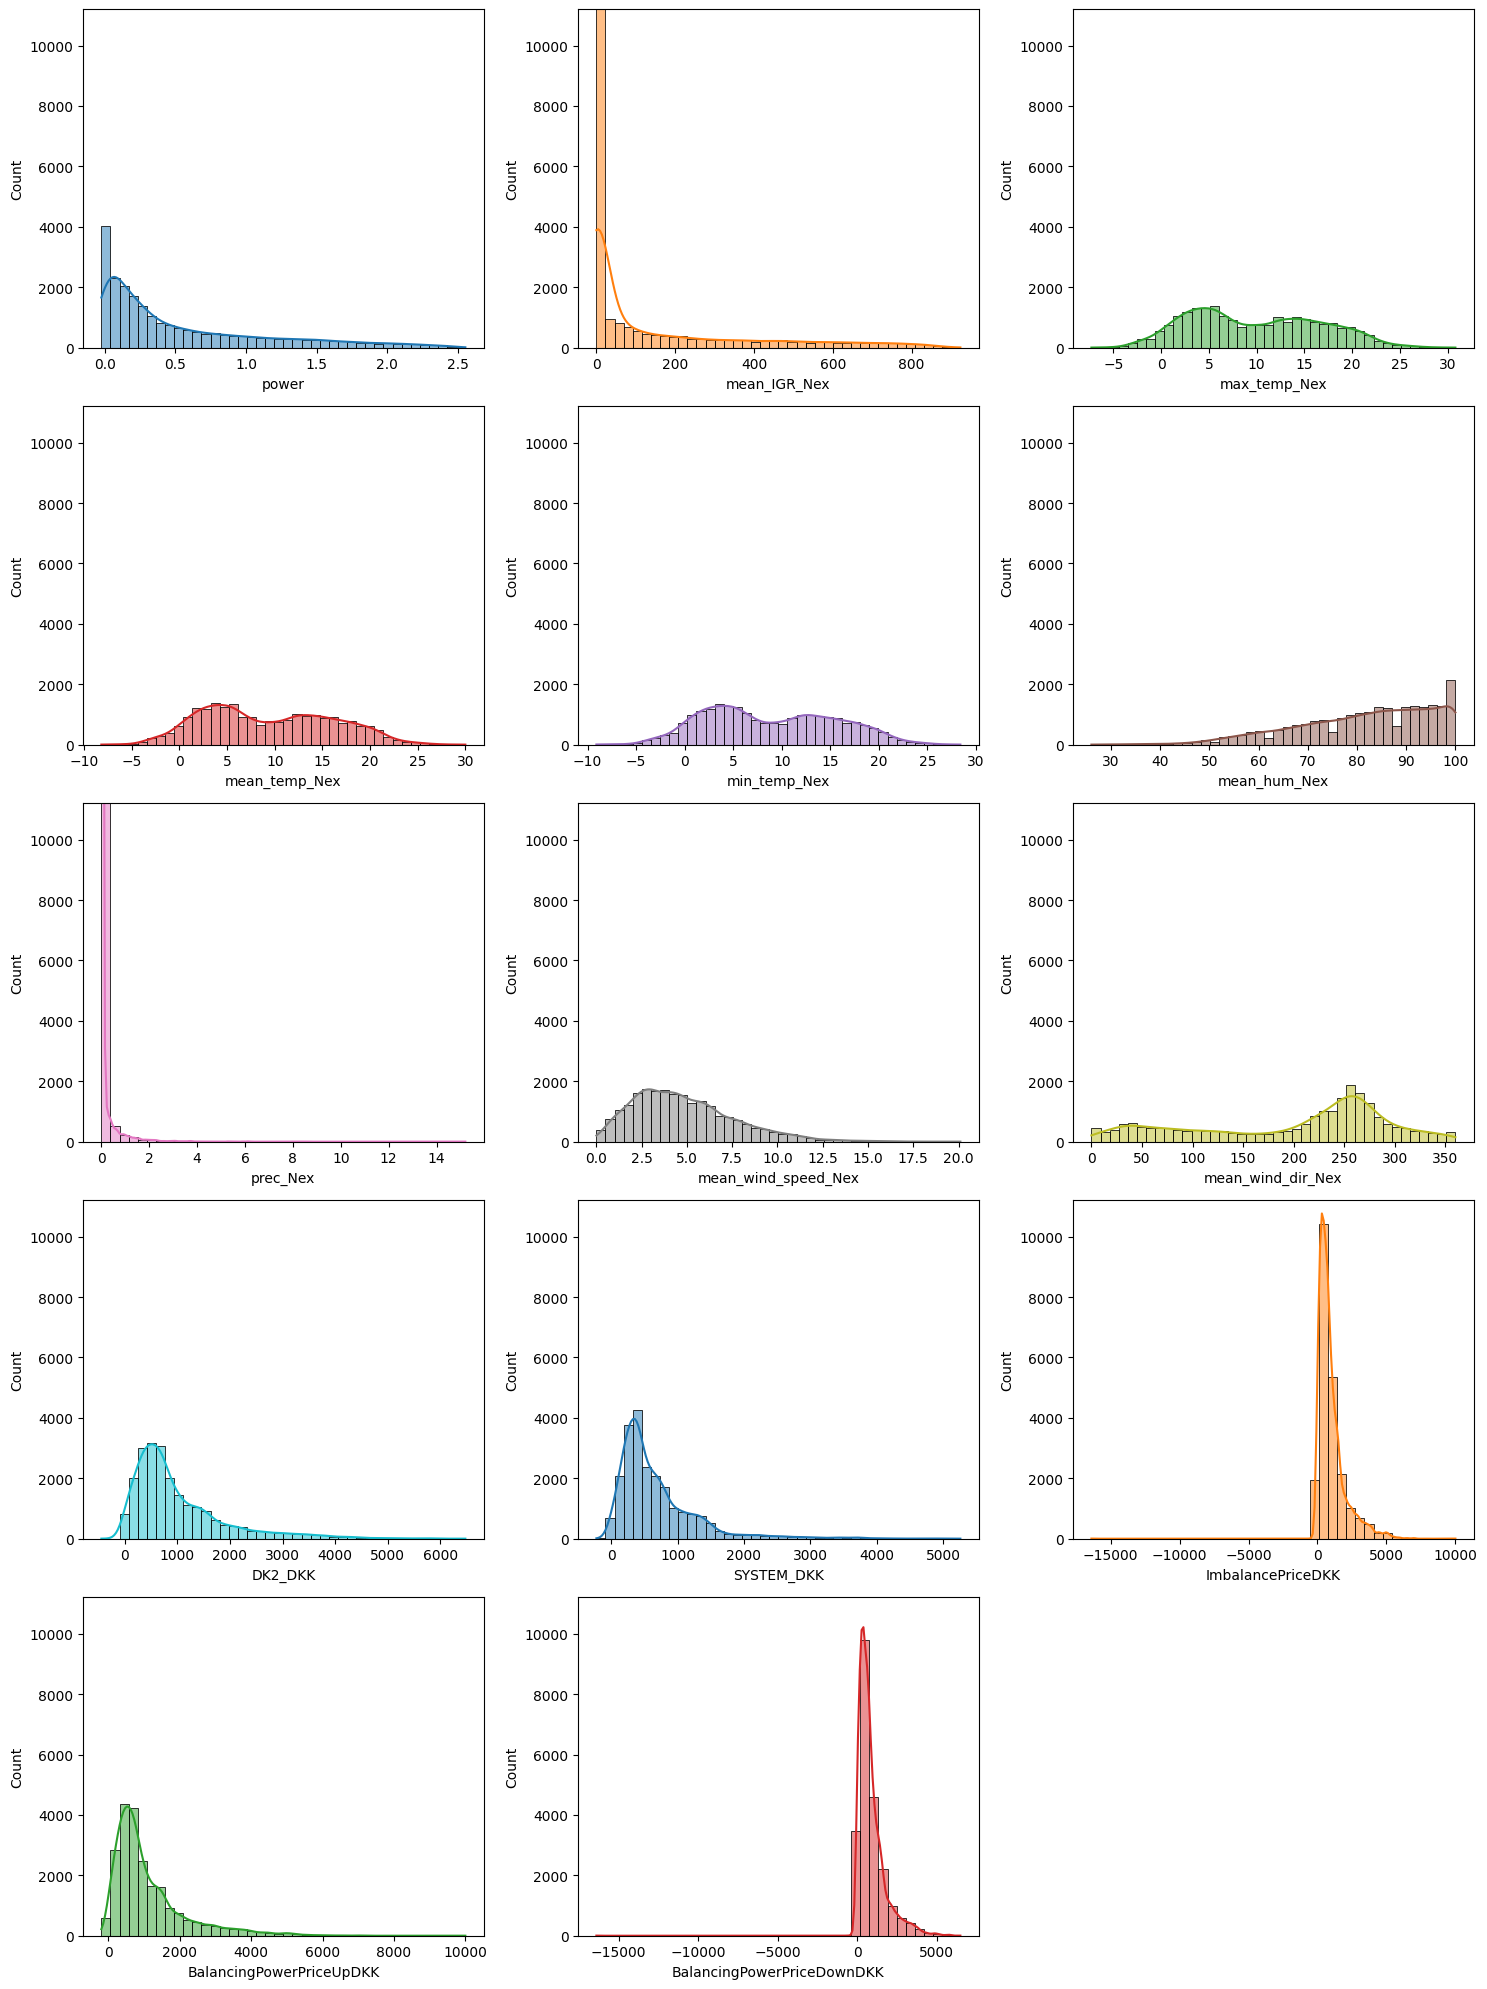

Histograms with KDE (Seaborn) done


In [25]:
# Select numeric features (excluding ts and PriceArea)
numeric_cols = numeric_df.columns
M = len(numeric_cols)
N = len(numeric_df)

# Grid size for subplots
u = math.ceil(M / 3)   # rows
v = 3                  # columns

plt.figure(figsize=(15, 4*u))
for i, col in enumerate(numeric_cols):
    plt.subplot(u, v, i + 1)
    sns.histplot(numeric_df[col].dropna(), kde=True, color=f"C{i % 10}", bins=40)
    plt.xlabel(col)
    plt.ylim(0, N / 2)
plt.tight_layout()
plt.show()

print("Histograms with KDE (Seaborn) done")


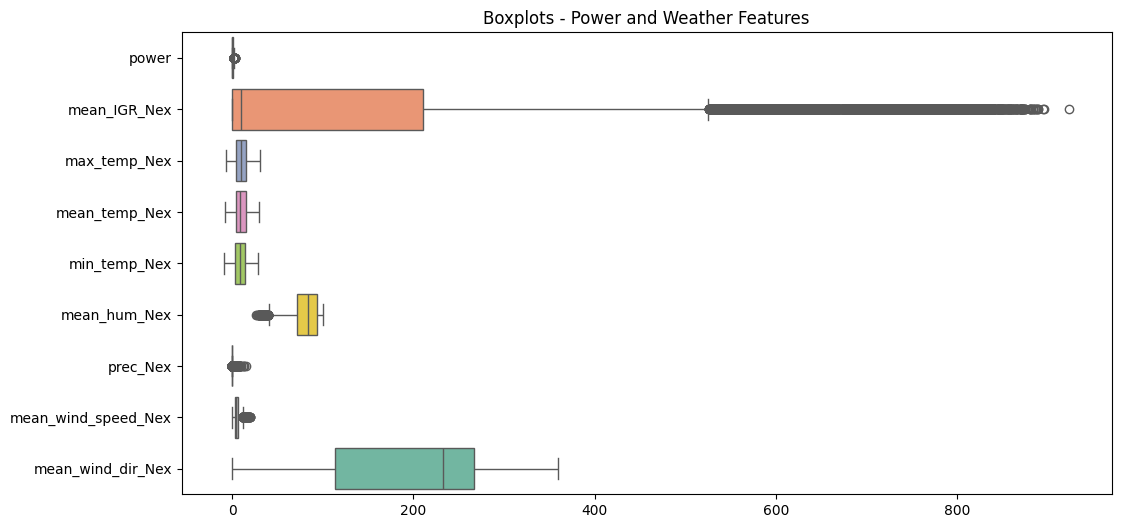

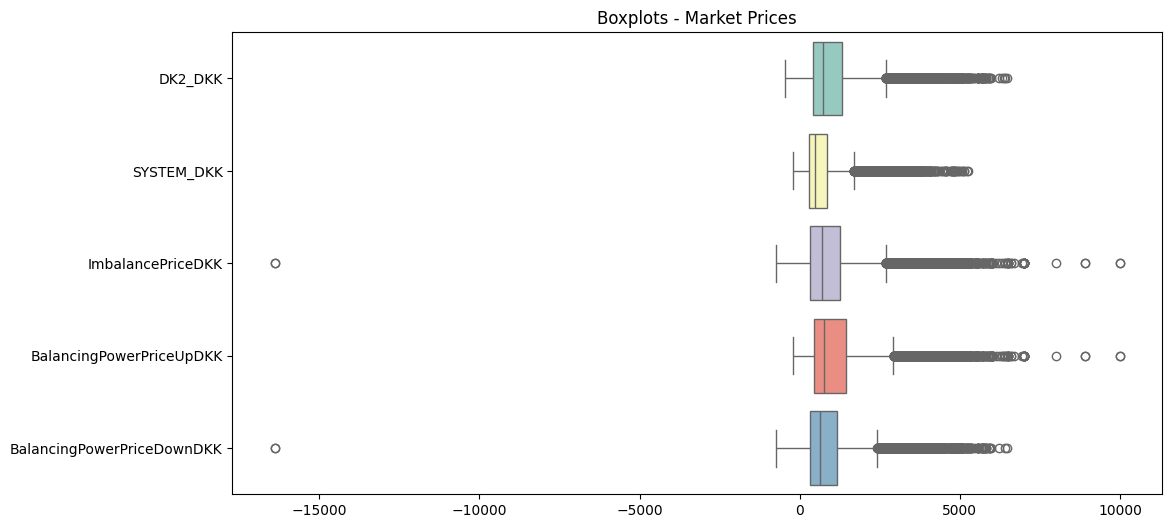

In [26]:
# Group 1: Power + Weather
power_weather_cols = [
    "power", "mean_IGR_Nex", "max_temp_Nex", "mean_temp_Nex", "min_temp_Nex",
    "mean_hum_Nex", "prec_Nex", "mean_wind_speed_Nex", "mean_wind_dir_Nex"
]

# Group 2: Prices
price_cols = [
    "DK2_DKK", "SYSTEM_DKK", "ImbalancePriceDKK",
    "BalancingPowerPriceUpDKK", "BalancingPowerPriceDownDKK"
]

# Plot Power + Weather
plt.figure(figsize=(12, 6))
sns.boxplot(data=numeric_df[power_weather_cols], orient="h", palette="Set2")
plt.title("Boxplots - Power and Weather Features")
plt.show()

# Plot Prices
plt.figure(figsize=(12, 6))
sns.boxplot(data=numeric_df[price_cols], orient="h", palette="Set3")
plt.title("Boxplots - Market Prices")
plt.show()


### Correlation Heatmap Insights

From the correlation heatmap, we can identify several distinct regions:

- **Market prices (DK2_DKK, SYSTEM_DKK, ImbalancePriceDKK, BalancingPowerPriceUp/DownDKK)**  
  - These variables are **highly correlated with each other** (ρ > 0.9).  
  - This suggests strong redundancy in information: using all of them may not add much value.  
  - In modeling, we could select just one representative price feature, or combine them.

- **Temperatures (max_temp_Nex, mean_temp_Nex, min_temp_Nex)**  
  - These features are **almost perfectly correlated** (ρ ≈ 1.0), which makes sense since they describe the same phenomenon.  
  - They are also **positively correlated with irradiance (mean_IGR_Nex)**, indicating sunny days tend to be warmer.  

- **Irradiance vs. Humidity**  
  - There is a **strong negative correlation** (ρ ≈ -0.57) between irradiance and humidity.  
  - This is consistent with physical reality: sunny periods often coincide with lower humidity.

- **Power vs. Wind Speed**  
  - Power has a **strong positive correlation** with mean wind speed (ρ ≈ 0.79), confirming the expected wind–power curve relationship.  
  - This is the most important predictor for power generation.

- **Power vs. Market Prices**  
  - There is a **weak negative correlation** with prices (ρ ≈ -0.2 to -0.3).  
  - This suggests that higher wind production may be associated with **lower market prices**, possibly due to supply–demand effects (more wind in the system pushes prices down).  

- **Precipitation, wind direction**  
  - These features show only **weak or no significant correlations** with power or prices.  
  - They may add little predictive value on their own, but could still interact with other features.


**Summary:**  
- Wind speed is the dominant driver of power.  
- Price variables are redundant and can be reduced.  
- Temperature variables are redundant but carry seasonal/irradiance information.  
- Irradiance and humidity capture complementary weather effects.  
- Power–price relationship is weakly negative, reflecting market dynamics.  

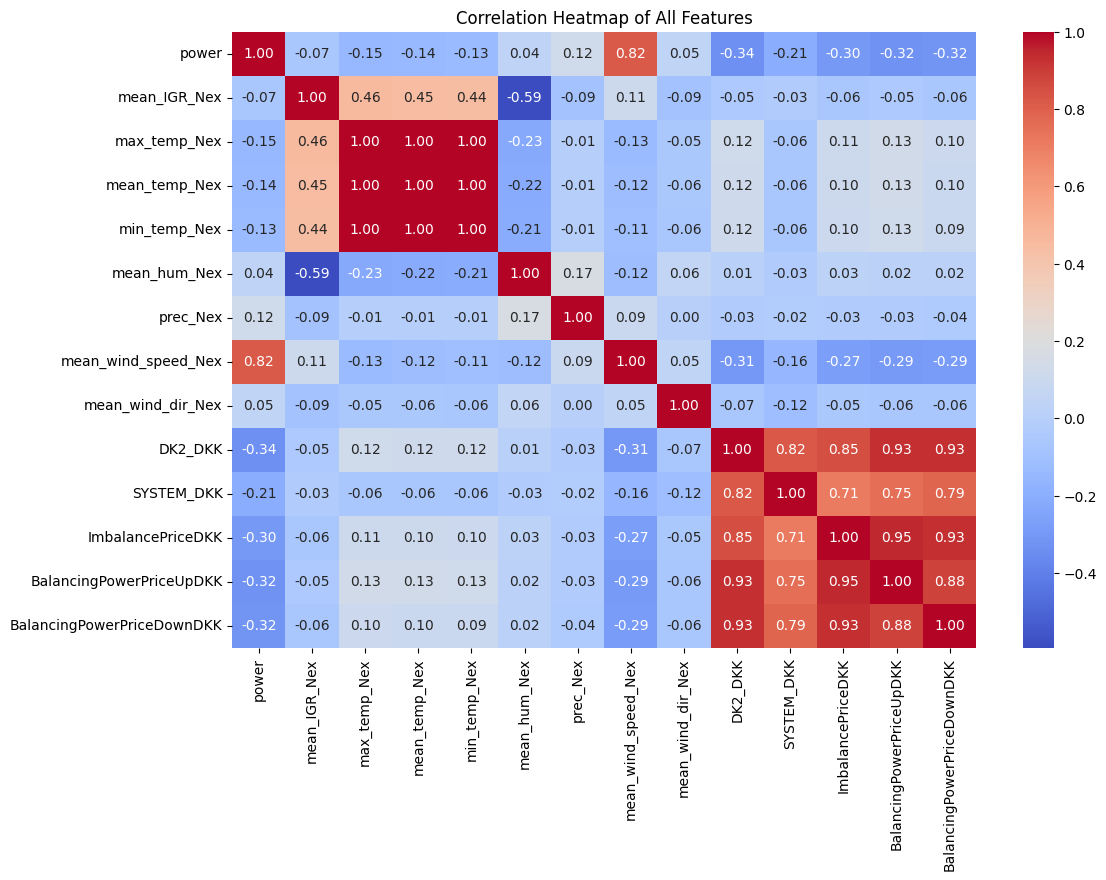

In [5]:
plt.figure(figsize=(12,8))
corr = numeric_df.corr()
sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Heatmap of All Features")
plt.show()

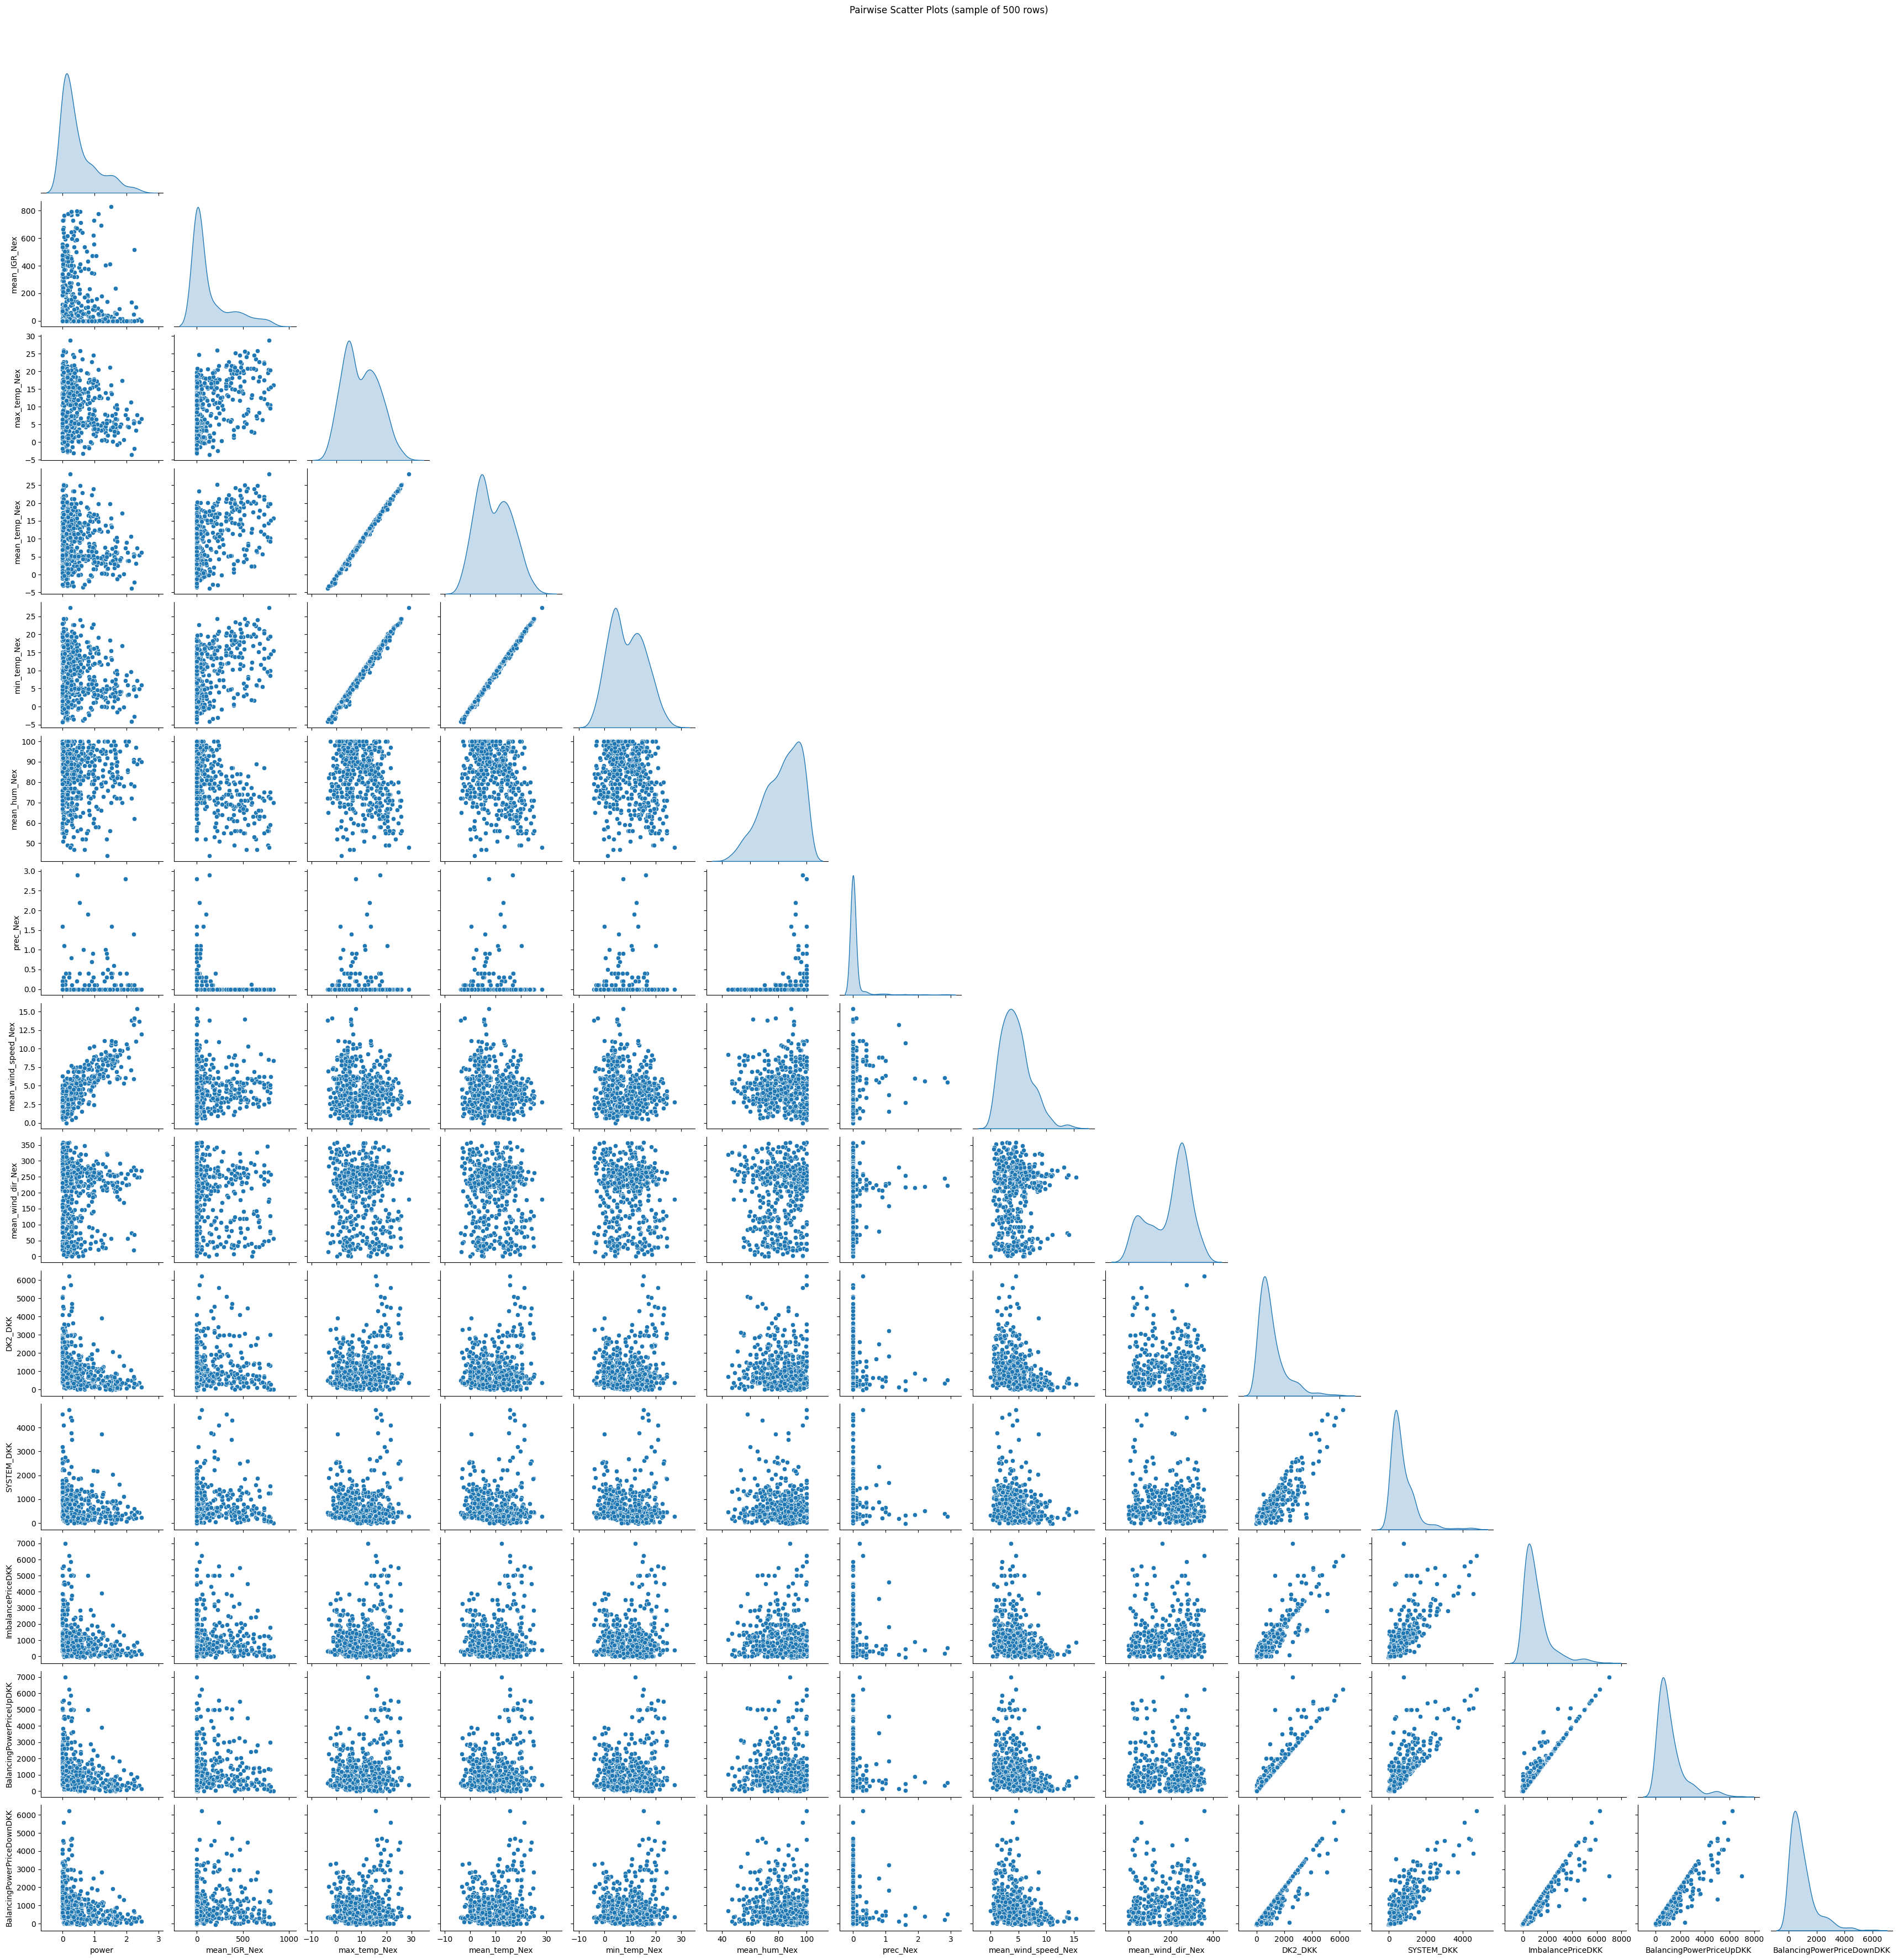

In [6]:
sns.pairplot(numeric_df.sample(500), diag_kind="kde", corner=True)
plt.suptitle("Pairwise Scatter Plots (sample of 500 rows)", y=1.02)
plt.show()

### Wind Direction Analysis
- The wind rose shows that winds are **not uniformly distributed** across directions.  
- **South-West (SW, ~30%)** and **West (W, ~16.5%)** are the dominant wind directions.  
- Secondary contributions come from **South (11%)** and **North (10%)**.  
- Eastern sectors (E, SE, NE, NW) together account for ~32% but individually remain below 10%.  

**Summary:**  
Most of the wind resource comes from **SW–W sectors**, consistent with the prevailing westerlies in Northern Europe.  
This is important both for **energy yield** (turbine orientation) and for **forecasting**, since direction clusters may align with weather fronts.

mean_wind_dir_Nex
N     10.649884
NE    10.002678
E      8.092305
SE     5.762364
S     11.346188
SW    30.990002
W     16.157829
NW     6.998750
Name: proportion, dtype: float64


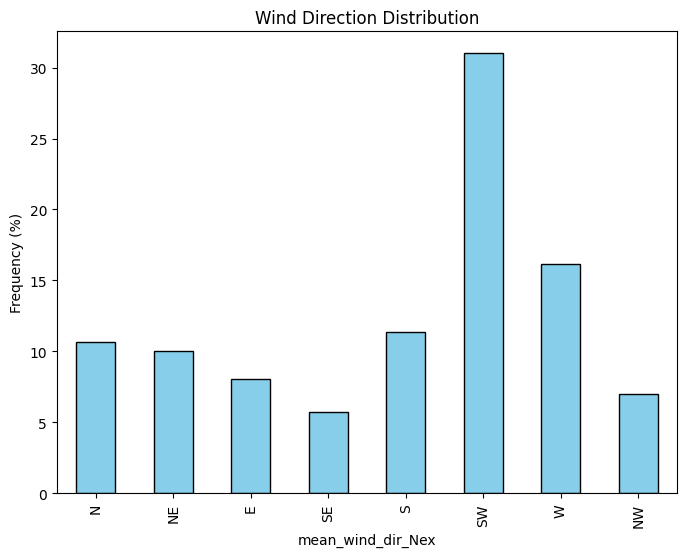

In [7]:
# Extract wind direction
wind_dir = train_df["mean_wind_dir_Nex"].dropna()

# Define compass sectors (45° each)
bins = [0, 45, 90, 135, 180, 225, 270, 315, 360]
labels = ["N", "NE", "E", "SE", "S", "SW", "W", "NW"]

# Categorize wind directions
wind_dir_cat = pd.cut(wind_dir, bins=bins, labels=labels, right=False, include_lowest=True)

# Count percentages
wind_counts = wind_dir_cat.value_counts(normalize=True).sort_index() * 100
print(wind_counts)

# Plot as bar chart
plt.figure(figsize=(8,6))
wind_counts.plot(kind="bar", color="skyblue", edgecolor="black")
plt.ylabel("Frequency (%)")
plt.title("Wind Direction Distribution")
plt.show()

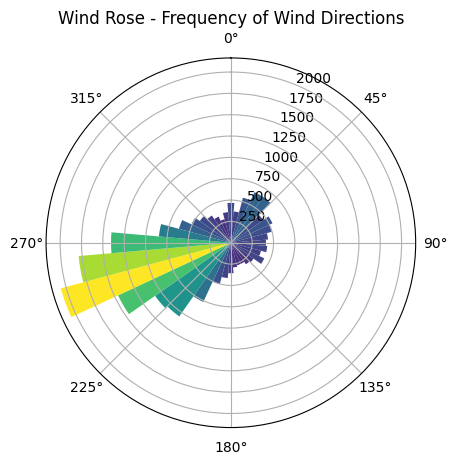

In [8]:
import matplotlib.cm as cm
# Convert to radians for polar plot
theta = np.deg2rad(wind_dir)

# Create bins for histogram
counts, bin_edges = np.histogram(theta, bins=36)  # 10° bins

# Polar plot
ax = plt.subplot(111, polar=True)
bars = ax.bar(bin_edges[:-1], counts, width=np.diff(bin_edges), bottom=0, color=cm.viridis(counts/ counts.max()))

ax.set_theta_zero_location("N")  # 0° at North
ax.set_theta_direction(-1)       # clockwise
plt.title("Wind Rose - Frequency of Wind Directions")
plt.show()

## 2. PCA

### Principal Component Interpretation (Energy Dataset)

Based on the scaled PCA, the first six components explain >90% of the variance, with the following dominant drivers:

- **PC1 – Prices**  
  Dominated by DK2_DKK, SYSTEM_DKK, ImbalancePriceDKK, Balancing Up/Down prices.  
  → Represents **market price volatility**.

- **PC2 – Temperature & Irradiance**  
  Strong loadings from min/mean/max temperature and irradiance (mean_IGR_Nex).  
  → Captures **seasonal/solar-related variability**.

- **PC3 – Power & Wind Speed**  
  High loadings on power output and mean_wind_speed_Nex.  
  → Reflects the **wind–power curve relationship**.

- **PC4 – Irradiance, Humidity & Precipitation**  
  Irradiance positive vs. humidity negative, with precipitation included.  
  → Captures **weather conditions and air moisture effects**.

- **PC5 – Wind Direction**  
  Dominated by mean_wind_dir_Nex.  
  → Represents **prevailing wind orientation** (important for system integration and forecasting regimes).

- **PC6 – Precipitation Residual**  
  Captures variance mainly from precipitation that wasn’t explained earlier.  
  → A **minor weather axis**.

 **Summary:**  
- Market prices form their own strong independent axis (PC1).  
- Weather splits across multiple PCs:  
  - **Temperatures & irradiance** (PC2)  
  - **Irradiance vs. humidity trade-off** (PC4)  
  - **Wind-related components** (PC3, PC5)  
- Precipitation contributes weakly and mostly to higher-order components.  
- PCA confirms redundancy among **prices** and **temperatures**, while highlighting **independent structure in wind, irradiance, and humidity**.

In [9]:
from sklearn.preprocessing import StandardScaler

# Select numeric features (exclude ts, PriceArea, ImbalanceMWh for now)
numeric_features = [
    "power", "mean_IGR_Nex", "max_temp_Nex", "mean_temp_Nex", "min_temp_Nex",
    "mean_hum_Nex", "prec_Nex", "mean_wind_speed_Nex", "mean_wind_dir_Nex",
    "DK2_DKK", "SYSTEM_DKK", "ImbalancePriceDKK",
    "BalancingPowerPriceUpDKK", "BalancingPowerPriceDownDKK"
]

scaler = StandardScaler()
scaled_data = scaler.fit_transform(train_df[numeric_features])

scaled_df = pd.DataFrame(scaled_data, columns=numeric_features, index=train_df.index)

print(scaled_df.head())

      power  mean_IGR_Nex  max_temp_Nex  mean_temp_Nex  min_temp_Nex  \
0 -0.673760     -0.640951     -0.881369      -0.850325     -0.817192   
1 -0.524803     -0.640951     -0.896010      -0.865153     -0.832158   
2 -0.639301     -0.640951     -0.881369      -0.894809     -0.906984   
3 -0.685076     -0.640951     -1.013132      -1.013430     -0.981810   
4 -0.732413     -0.640951     -1.086334      -1.057913     -1.041671   

   mean_hum_Nex  prec_Nex  mean_wind_speed_Nex  mean_wind_dir_Nex   DK2_DKK  \
0     -0.052472 -0.175471            -0.688169           0.051077 -0.711526   
1      0.165678 -0.175471            -0.831034          -0.032003 -0.740632   
2      0.601979  0.541789            -0.473871          -0.042388 -0.755219   
3      0.820129  0.063616            -0.795318          -0.000848 -0.776202   
4      1.110996 -0.175471            -1.223914          -0.218932 -0.777773   

   SYSTEM_DKK  ImbalancePriceDKK  BalancingPowerPriceUpDKK  \
0   -0.815898          -0.6172

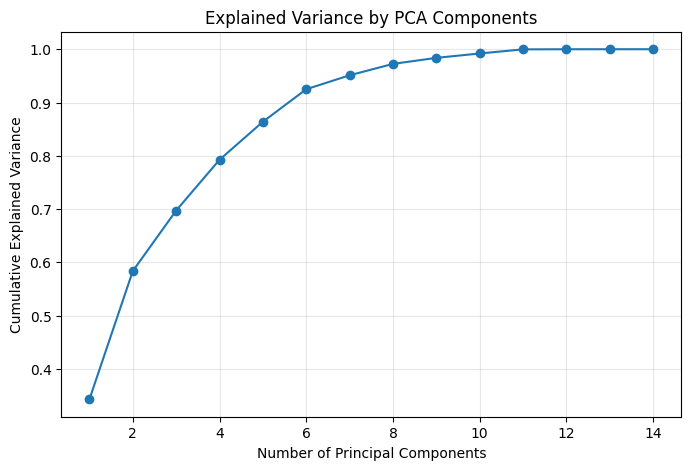

                                 PC1       PC2       PC3
power                      -0.222856 -0.040345  0.586111
mean_IGR_Nex                0.023292  0.357595  0.215422
max_temp_Nex                0.136749  0.499976 -0.026592
mean_temp_Nex               0.135427  0.499306 -0.021728
min_temp_Nex                0.133647  0.497791 -0.016012
mean_hum_Nex               -0.020173 -0.232120 -0.269708
prec_Nex                   -0.030821 -0.029418  0.084192
mean_wind_speed_Nex        -0.204929 -0.005729  0.657681
mean_wind_dir_Nex          -0.049895 -0.038959 -0.043040
DK2_DKK                     0.428838 -0.096127  0.105498
SYSTEM_DKK                  0.358831 -0.164278  0.213182
ImbalancePriceDKK           0.416703 -0.102024  0.114261
BalancingPowerPriceUpDKK    0.427086 -0.092040  0.108202
BalancingPowerPriceDownDKK  0.424669 -0.109621  0.114305


In [10]:
from sklearn.decomposition import PCA
# PCA
pca = PCA()
pca.fit(scaled_df)

# Variance explained
explained_var = np.cumsum(pca.explained_variance_ratio_)

plt.figure(figsize=(8,5))
plt.plot(range(1, len(explained_var)+1), explained_var, marker="o")
plt.xlabel("Number of Principal Components")
plt.ylabel("Cumulative Explained Variance")
plt.title("Explained Variance by PCA Components")
plt.grid(True, alpha=0.3)
plt.show()

# Show component loadings (first few PCs)
pca_loadings = pd.DataFrame(pca.components_.T,
                            columns=[f"PC{i+1}" for i in range(len(numeric_features))],
                            index=numeric_features)
print(pca_loadings.iloc[:, :3])  # top 3 PCs

In [11]:
from scipy.linalg import svd
import numpy as np

X = train_df[numeric_features].values.astype(float)
N, M = X.shape
attributeNames = numeric_features

# Center data
Y1 = X - np.ones((N, 1)) * X.mean(axis=0)

# Center + standardize
Y2 = (X - np.ones((N, 1)) * X.mean(axis=0)) / np.std(X, axis=0)

Ys = [Y1, Y2]
titles = ["Zero-mean", "Zero-mean and unit variance"]
threshold = 0.9

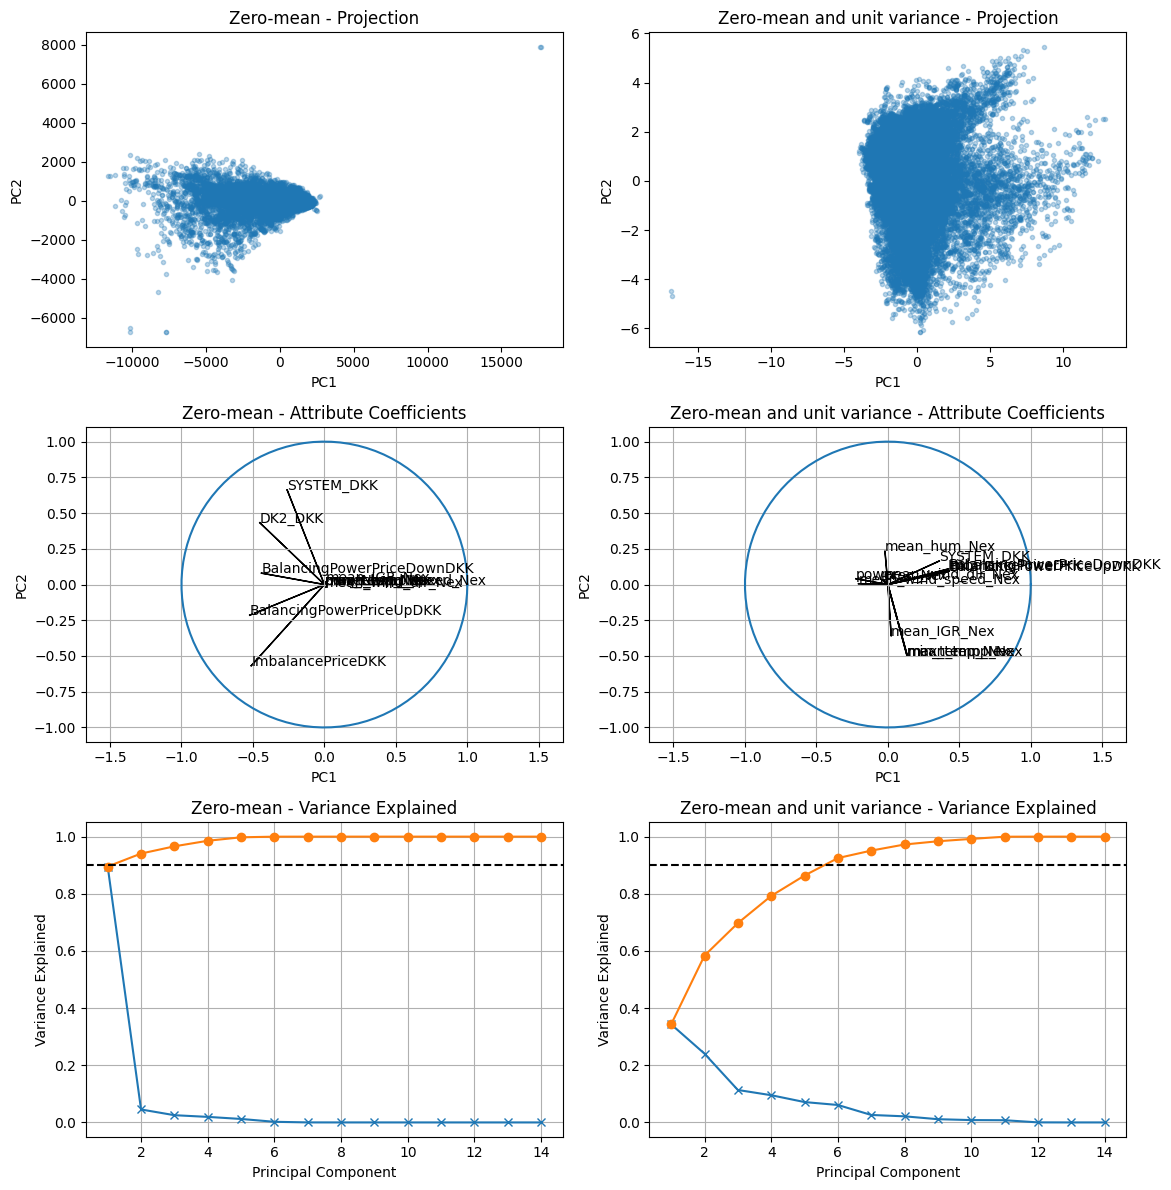

In [12]:
i, j = 0, 1  # First two PCs for plotting

plt.figure(figsize=(12, 12))
for k, Y in enumerate(Ys):
    # PCA via SVD
    U, S, Vh = svd(Y, full_matrices=False)
    V = Vh.T
    if k == 1:  # flip sign for consistency
        V = -V
        U = -U

    rho = (S**2) / (S**2).sum()
    Z = U * S  # projections

    # 1) Projection onto first two PCs
    plt.subplot(3, 2, 1 + k)
    plt.plot(Z[:, i], Z[:, j], ".", alpha=0.3)
    plt.xlabel(f"PC{i+1}")
    plt.ylabel(f"PC{j+1}")
    plt.title(f"{titles[k]} - Projection")

    # 2) Attribute coefficients in PC space
    plt.subplot(3, 2, 3 + k)
    for att in range(V.shape[0]):
        plt.arrow(0, 0, V[att, i], V[att, j])
        plt.text(V[att, i], V[att, j], attributeNames[att])
    plt.xlim([-1, 1])
    plt.ylim([-1, 1])
    plt.xlabel(f"PC{i+1}")
    plt.ylabel(f"PC{j+1}")
    plt.grid()
    plt.plot(np.cos(np.linspace(0, 2*np.pi, 100)), np.sin(np.linspace(0, 2*np.pi, 100)))
    plt.title(f"{titles[k]} - Attribute Coefficients")
    plt.axis("equal")

    # 3) Variance explained
    plt.subplot(3, 2, 5 + k)
    plt.plot(range(1, len(rho)+1), rho, "x-")
    plt.plot(range(1, len(rho)+1), np.cumsum(rho), "o-")
    plt.axhline(y=threshold, color="k", linestyle="--")
    plt.xlabel("Principal Component")
    plt.ylabel("Variance Explained")
    plt.title(f"{titles[k]} - Variance Explained")
    plt.grid()

plt.tight_layout()
plt.show()

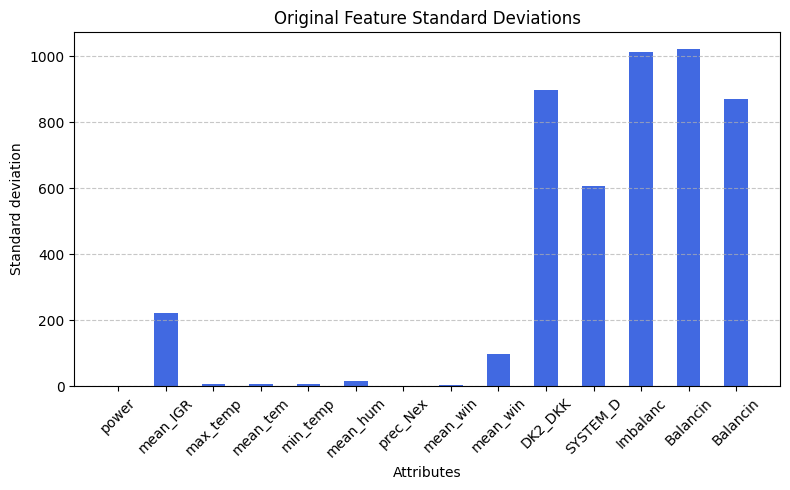

In [13]:
r = np.arange(1, X.shape[1] + 1)

plt.figure(figsize=(8, 5))
plt.bar(r, np.std(X, axis=0), width=0.5, color='royalblue')
plt.xticks(r, [a[:8] for a in attributeNames], fontsize=10, rotation=45)
plt.ylabel("Standard deviation")
plt.xlabel("Attributes")
plt.title("Original Feature Standard Deviations")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

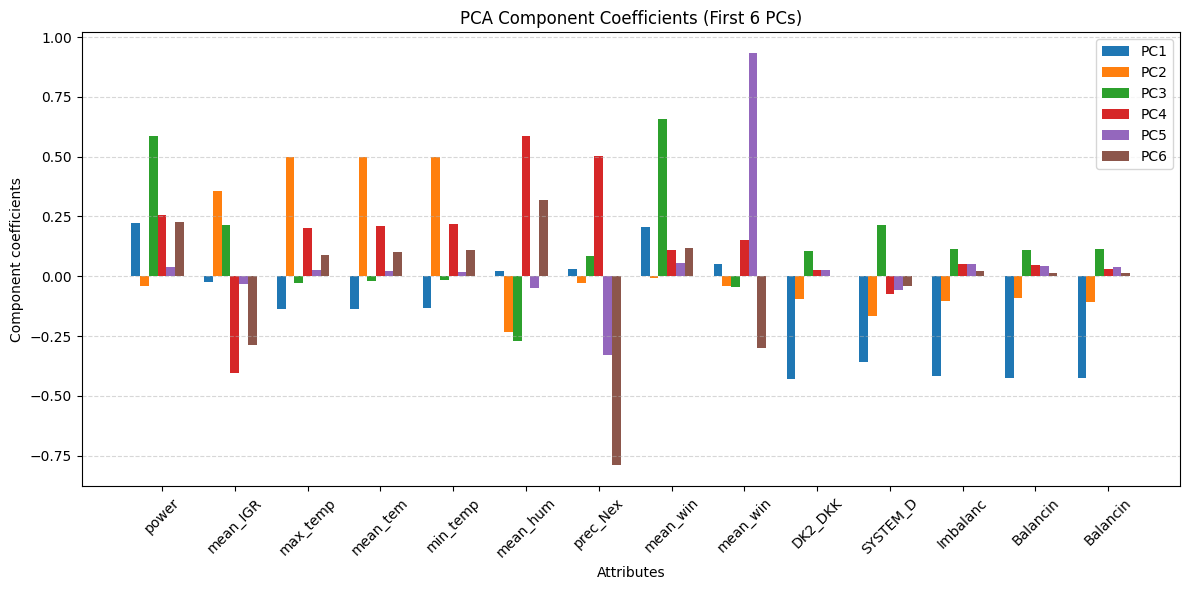

In [14]:
# Example: look at loadings for first 6 PCs (standardized case Y2) - 90 % `explained by 6 PCs
# Take standardized case (Y2)
U, S, Vh = svd(Y2, full_matrices=False)
V = Vh.T   # loadings

pcs = [0,1,2,3,4,5]  # first 6 PCs
legendStrs = [f"PC{i+1}" for i in pcs]
bw = 0.12  # bar width
r = np.arange(1, X.shape[1]+1)

plt.figure(figsize=(12,6))
for i in pcs:
    plt.bar(r + i*bw, V[:, i], width=bw, label=f"PC{i+1}")

plt.xticks(r + bw*len(pcs)/2, [a[:8] for a in attributeNames], rotation=45)
plt.xlabel("Attributes")
plt.ylabel("Component coefficients")
plt.title("PCA Component Coefficients (First 6 PCs)")
plt.legend()
plt.grid(True, axis="y", linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()

## 3. Forw & Backw selection

In [15]:
target_col = "power"
X = numeric_df.drop(columns=[target_col]).values
y = numeric_df[target_col].values
feature_names = list(numeric_df.drop(columns=[target_col]).columns)

In [16]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X = scaler.fit_transform(X)

### Rolling-Origin Time Series Splits

We use a **rolling-origin (sliding window) cross-validation scheme** to evaluate models in a way that respects time ordering:

- **Training window (`window`)**: The size of the historical data used for fitting.  
  Example: `"2M"` means each model sees 2 months of history.  
- **Validation horizon (`horizon`)**: The length of the future period reserved for validation.  
  Example: `"1M"` means we predict the next month.  
- **Step size (`step`)**: How far forward the origin is moved after each split.  
  Example: `"1M"` means the window slides forward by one month each time.

#### Behavior
1. Start at the earliest timestamp.  
2. Use `[start … start+window)` as the **training period**.  
3. Use `[train_end … train_end+horizon)` as the **validation period**.  
4. Advance `start` by `step` and repeat.  
5. Stop when there is not enough data left to cover the full validation horizon.

#### Why this is important
- Unlike random K-fold splits, this scheme **avoids leakage** from the future into the past.  
- It mimics how models will actually be used in forecasting:  
  **train on history → predict the next block → slide forward**.  
- Multiple splits ensure robustness to seasonal effects and time-varying behavior.

#### Example (2M train, 1M validation, 1M step)
- **Split 1:** Train = Jan–Feb, Validate = Mar  
- **Split 2:** Train = Feb–Mar, Validate = Apr  
- **Split 3:** Train = Mar–Apr, Validate = May  
- … etc.  


In [17]:
def build_time_splits(ts, window="6M", horizon="1M", step=None, verbose=True):
    """
    Rolling-origin time series splits (sliding window).
    Ensures validation covers the full horizon.
    """
    import pandas as pd
    ts = pd.to_datetime(pd.Series(ts)).sort_values().reset_index(drop=True)

    if step is None:
        step = horizon

    splits = []
    split_id = 1
    start_time = ts.min()

    while True:
        train_end = start_time + pd.tseries.frequencies.to_offset(window)
        val_end   = train_end + pd.tseries.frequencies.to_offset(horizon)

        # stop if val_end goes beyond dataset max
        if val_end > ts.max():
            break

        train_idx = ts[(ts >= start_time) & (ts < train_end)].index.values
        val_idx   = ts[(ts >= train_end) & (ts < val_end)].index.values

        if len(val_idx) == 0 or len(train_idx) == 0:
            break

        splits.append((train_idx, val_idx))

        if verbose:
            print(f"Split {split_id}:")
            print(f"  Train: {ts.iloc[train_idx[0]]} → {ts.iloc[train_idx[-1]]}")
            print(f"  Valid: {ts.iloc[val_idx[0]]} → {ts.iloc[val_idx[-1]]}")
            print(f"End {split_id}:" + "-"*40)

        start_time = start_time + pd.tseries.frequencies.to_offset(step)
        split_id += 1

    return splits
# Example usage
ts = train_df["ts"].values
time_splits = build_time_splits(ts, window="2M", horizon="1M", step="1M", verbose=True)

print(f"Created {len(time_splits)} rolling splits.")

Split 1:
  Train: 2021-01-01 00:00:00 → 2021-02-26 17:00:00
  Valid: 2021-03-01 12:00:00 → 2021-03-30 23:00:00
End 1:----------------------------------------
Split 2:
  Train: 2021-01-31 00:00:00 → 2021-03-30 23:00:00
  Valid: 2021-03-31 00:00:00 → 2021-04-29 23:00:00
End 2:----------------------------------------
Split 3:
  Train: 2021-03-01 12:00:00 → 2021-04-29 23:00:00
  Valid: 2021-04-30 00:00:00 → 2021-05-30 23:00:00
End 3:----------------------------------------
Split 4:
  Train: 2021-03-31 00:00:00 → 2021-05-30 23:00:00
  Valid: 2021-05-31 00:00:00 → 2021-06-29 23:00:00
End 4:----------------------------------------
Split 5:
  Train: 2021-04-30 00:00:00 → 2021-06-29 23:00:00
  Valid: 2021-06-30 00:00:00 → 2021-07-30 23:00:00
End 5:----------------------------------------
Split 6:
  Train: 2021-05-31 00:00:00 → 2021-07-30 23:00:00
  Valid: 2021-07-31 00:00:00 → 2021-08-30 23:00:00
End 6:----------------------------------------
Split 7:
  Train: 2021-06-30 00:00:00 → 2021-08-30 2

/var/folders/v4/lzkm2zzd3gb0q8rqggx5drch0000gn/T/ipykernel_38747/1457188229.py:17: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  train_end = start_time + pd.tseries.frequencies.to_offset(window)
/var/folders/v4/lzkm2zzd3gb0q8rqggx5drch0000gn/T/ipykernel_38747/1457188229.py:18: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  val_end   = train_end + pd.tseries.frequencies.to_offset(horizon)
/var/folders/v4/lzkm2zzd3gb0q8rqggx5drch0000gn/T/ipykernel_38747/1457188229.py:38: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  start_time = start_time + pd.tseries.frequencies.to_offset(step)


Simple linear regression model to be trained on the rolling splits and validated on the average of the rmses over the splits.

In [18]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import numpy as np

def eval_subset_rmse(X, y, feature_idx, splits):
    """Evaluate RMSE for a feature subset using rolling-origin splits."""
    rmses = []
    for tr_idx, va_idx in splits:
        if len(feature_idx) == 0:
            # mean predictor baseline
            yhat = np.full_like(y[va_idx], y[tr_idx].mean(), dtype=float)
        else:
            model = LinearRegression()
            model.fit(X[tr_idx][:, feature_idx], y[tr_idx])
            yhat = model.predict(X[va_idx][:, feature_idx])
        rmses.append(np.sqrt(mean_squared_error(y[va_idx], yhat)))
    return np.mean(rmses), rmses

Forward selection starting with empty features, proceeding with +1 feature that has the best impact on the final mean rmse.

In [19]:
def forward_selection(X, y, feature_names, splits, tol=1e-3):
    M = X.shape[1]
    remaining = list(range(M))
    selected = []
    best_loss, _ = eval_subset_rmse(X, y, selected, splits)  # baseline
    loss_record = [best_loss]
    features_record = []

    print(f"[FS] start baseline RMSE={best_loss:.3f}")

    while remaining:
        cand_losses = []
        for f in remaining:
            new_subset = selected + [f]
            mean_rmse, _ = eval_subset_rmse(X, y, new_subset, splits)
            cand_losses.append((mean_rmse, f))
        cand_losses.sort()
        best_cand_loss, best_feat = cand_losses[0]

        if best_loss - best_cand_loss < tol:  # no improvement
            break

        selected.append(best_feat)
        remaining.remove(best_feat)
        best_loss = best_cand_loss
        loss_record.append(best_loss)

        mask = np.zeros(M, dtype=int)
        mask[selected] = 1
        features_record.append(mask)

        print(f"[FS] add {feature_names[best_feat]} → RMSE={best_loss:.3f}")

    return selected, np.array(loss_record), np.stack(features_record, axis=1)

fs_selected, fs_loss, fs_features = forward_selection(X, y, feature_names, time_splits)

print("\n[FS] Final selected features:")
print([feature_names[i] for i in fs_selected])

[FS] start baseline RMSE=0.591
[FS] add mean_wind_speed_Nex → RMSE=0.344
[FS] add mean_hum_Nex → RMSE=0.335
[FS] add BalancingPowerPriceUpDKK → RMSE=0.326
[FS] add mean_IGR_Nex → RMSE=0.324

[FS] Final selected features:
['mean_wind_speed_Nex', 'mean_hum_Nex', 'BalancingPowerPriceUpDKK', 'mean_IGR_Nex']


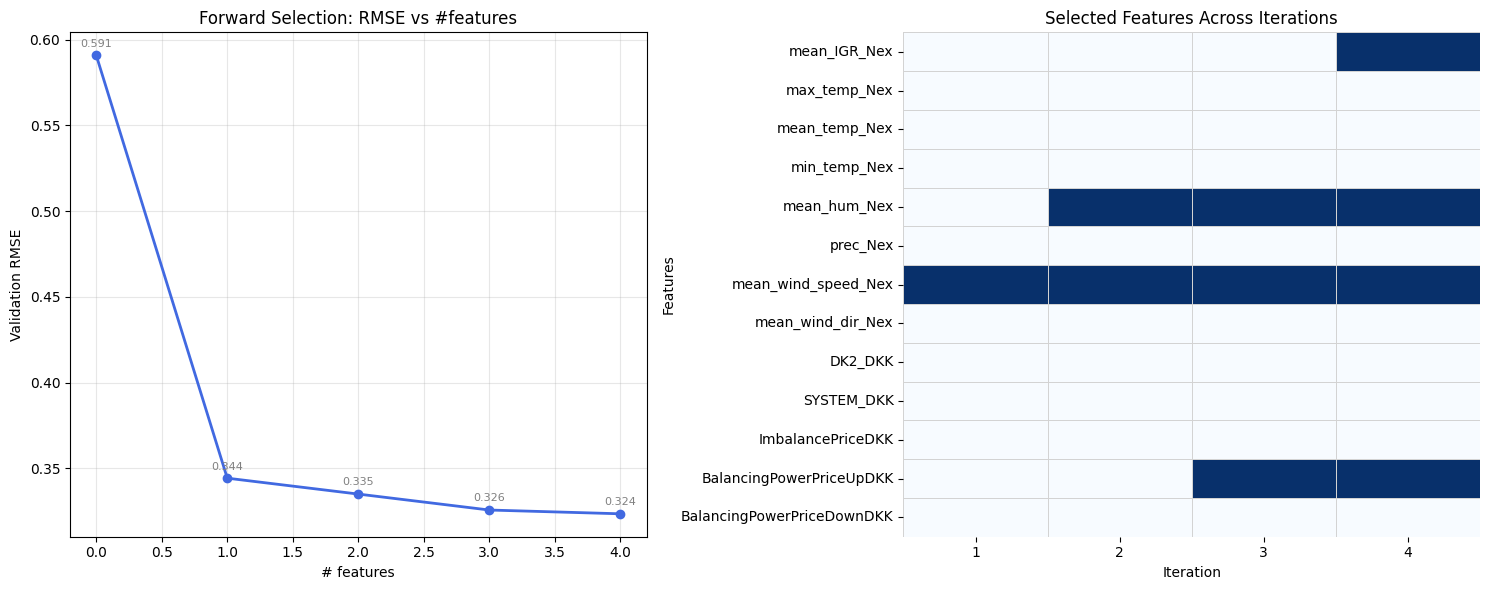

In [20]:
def plot_fs_path(feature_names, loss_record, features_record, title="Forward Selection"):
    fig, axes = plt.subplots(1, 2, figsize=(15, 6))

    # --- Error curve (left) ---
    axes[0].plot(range(len(loss_record)), loss_record, marker="o", color="royalblue", linewidth=2)
    for i, v in enumerate(loss_record):
        axes[0].text(i, v + 0.005, f"{v:.3f}", ha="center", fontsize=8, color="gray")
    axes[0].set_xlabel("# features")
    axes[0].set_ylabel("Validation RMSE")
    axes[0].set_title(f"{title}: RMSE vs #features")
    axes[0].grid(True, alpha=0.3)

    # --- Feature selection mask (right) ---
    mat = features_record
    sns.heatmap(mat, cmap="Blues", cbar=False, ax=axes[1], linewidths=0.5, linecolor="lightgray",
                annot=False, xticklabels=[f"{i+1}" for i in range(mat.shape[1])],
                yticklabels=feature_names)

    axes[1].set_xlabel("Iteration")
    axes[1].set_ylabel("Features")
    axes[1].set_title("Selected Features Across Iterations")

    plt.tight_layout()
    plt.show()

plot_fs_path(feature_names, fs_loss, fs_features, "Forward Selection")

Backward selection starting with full features, proceeding with -1 feature that has the best impact on the final mean rmse.

In [21]:
def backward_elimination(X, y, feature_names, splits, tol=1e-3):
    """
    Backward elimination with time-aware validation.
    Start with all features, remove one at a time if RMSE improves.
    """
    M = X.shape[1]
    selected = list(range(M))  # start with ALL features
    best_loss, _ = eval_subset_rmse(X, y, selected, splits)
    loss_record = [best_loss]
    features_record = [np.ones(M, dtype=int)]

    print(f"[BE] start with all features RMSE={best_loss:.3f}")

    while len(selected) > 1:
        cand_losses = []
        for f in selected:
            tmp = selected.copy()
            tmp.remove(f)
            mean_rmse, _ = eval_subset_rmse(X, y, tmp, splits)
            cand_losses.append((mean_rmse, f))

        # best feature to remove = lowest loss after removal
        cand_losses.sort()
        best_cand_loss, drop_feat = cand_losses[0]

        if best_loss - best_cand_loss < tol:  # stop if no improvement
            break

        selected.remove(drop_feat)
        best_loss = best_cand_loss
        loss_record.append(best_loss)

        mask = np.zeros(M, dtype=int)
        mask[selected] = 1
        features_record.append(mask)

        print(f"[BE] drop {feature_names[drop_feat]} → RMSE={best_loss:.3f}")

    return selected, np.array(loss_record), np.stack(features_record, axis=1)

be_selected, be_loss, be_features = backward_elimination(X, y, feature_names, time_splits)

print("\n[BE] Final selected features:")
print([feature_names[i] for i in be_selected])

[BE] start with all features RMSE=0.961
[BE] drop ImbalancePriceDKK → RMSE=0.333
[BE] drop BalancingPowerPriceDownDKK → RMSE=0.328
[BE] drop prec_Nex → RMSE=0.327
[BE] drop SYSTEM_DKK → RMSE=0.325

[BE] Final selected features:
['mean_IGR_Nex', 'max_temp_Nex', 'mean_temp_Nex', 'min_temp_Nex', 'mean_hum_Nex', 'mean_wind_speed_Nex', 'mean_wind_dir_Nex', 'DK2_DKK', 'BalancingPowerPriceUpDKK']


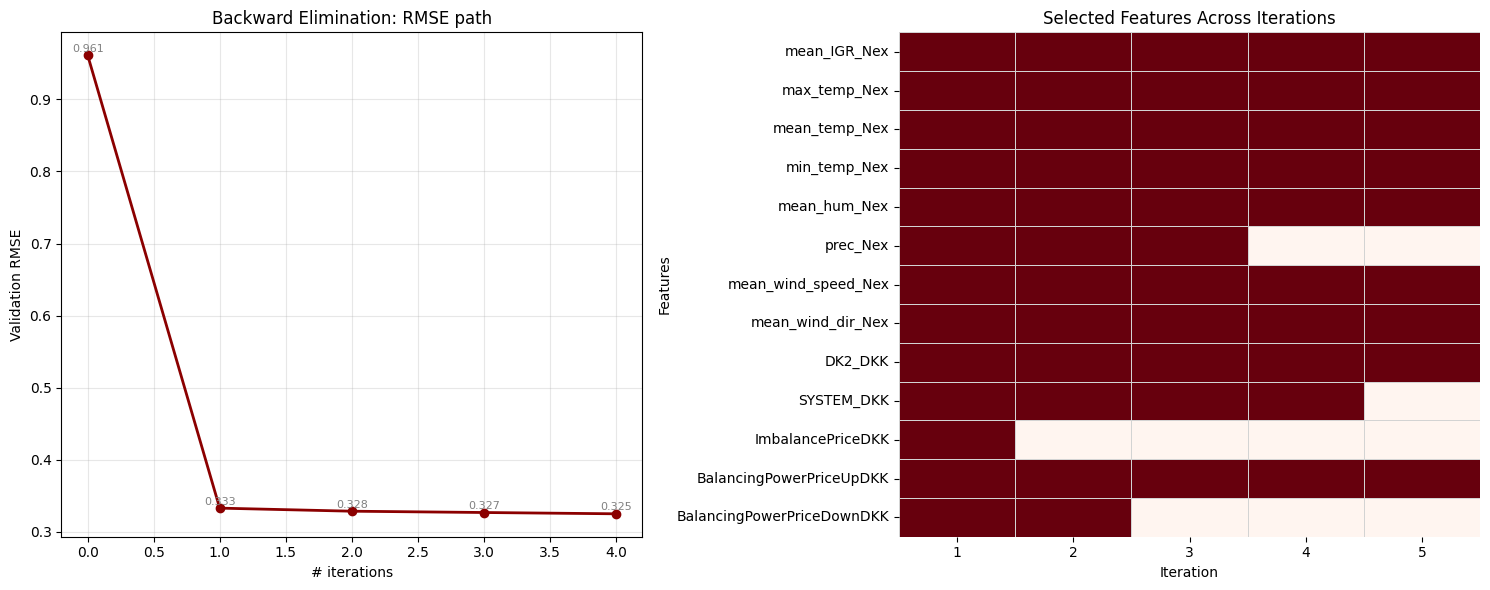

In [22]:
def plot_be_path(feature_names, loss_record, features_record, title="Backward Elimination"):
    import seaborn as sns
    import matplotlib.pyplot as plt

    fig, axes = plt.subplots(1, 2, figsize=(15, 6))

    # Error curve
    axes[0].plot(range(len(loss_record)), loss_record, marker="o", color="darkred", linewidth=2)
    for i, v in enumerate(loss_record):
        axes[0].text(i, v + 0.005, f"{v:.3f}", ha="center", fontsize=8, color="gray")
    axes[0].set_xlabel("# iterations")
    axes[0].set_ylabel("Validation RMSE")
    axes[0].set_title(f"{title}: RMSE path")
    axes[0].grid(True, alpha=0.3)

    # Heatmap
    sns.heatmap(features_record, cmap="Reds", cbar=False, ax=axes[1],
                linewidths=0.5, linecolor="lightgray",
                xticklabels=[f"{i+1}" for i in range(features_record.shape[1])],
                yticklabels=feature_names)
    axes[1].set_xlabel("Iteration")
    axes[1].set_ylabel("Features")
    axes[1].set_title("Selected Features Across Iterations")

    plt.tight_layout()
    plt.show()

# Example usage
plot_be_path(feature_names, be_loss, be_features)

### Results of Forward and Backward Feature Selection

#### Observations from Forward Selection
- Baseline (mean predictor) RMSE ≈ **0.59**.
- Adding **mean_wind_speed_Nex** yields the largest improvement → RMSE drops to ≈ **0.365**.
- Adding more features (precipitation, irradiance, balancing price down) gives only **small marginal gains**, with RMSE stabilizing at ≈ **0.343**.
- After 3–4 features, the error curve flattens → **diminishing returns**.

#### Observations from Backward Elimination
- Starting with all features, RMSE is high (≈ **1.14**) due to **noise and multicollinearity**.
- Removing redundant features rapidly improves RMSE to ≈ **0.35**.
- Final subset again centers on **wind speed**, with a few supporting weather/market features.
- Confirms that **too many features can harm performance** in linear models.

#### Key Conclusions
- **Both methods converge to ~0.34 RMSE**, indicating a **performance ceiling** for linear regression on this dataset.
- **Wind speed** is consistently the most important predictor of power production.
- Other features provide **only marginal benefit**.
- The residual variability in power is **nonlinear** and not well captured by a simple linear model.

#### Implications
1. **Linear regression is too limited**:  
   - The wind–power relationship is nonlinear (cubic at low speeds, saturation at high speeds).  
   - Linear models cannot capture these dynamics effectively.

2. **Feature selection validates the physics**:  
   - Wind speed dominates prediction.  
   - Irradiance, humidity, and market prices add only minor contributions.

3. **Next steps**:  
   - Explore **nonlinear models**:
     - Polynomial regression (e.g., quadratic/cubic terms of wind speed).  
     - Regularized linear models (Ridge, Lasso) to handle correlations.  
     - Nonlinear approaches (Random Forests, Gradient Boosting, Artificial Neural Networks).  
   - Goal: reduce RMSE significantly below **0.34**.